<a href="https://colab.research.google.com/github/jb3618columbia/Multiobjective-Optimization/blob/main/DNNs_Canonical_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
from typing import List, Optional

import torch
from torch import nn
from torch.optim.optimizer import Optimizer


class TrainableVector(torch.nn.Module):
  """
  Initializes a vector. Forwards the vector
  """
  def __init__(self, output_size=2, init_box=2.0):
      super(TrainableVector, self).__init__()

      # Randomly initialized vector
      self.vector = nn.Parameter(-1.0 * init_box + 2 * init_box * torch.rand(output_size))

  def forward(self):
      # Forward method is the current vector feedword the network
      output = self.vector
      return output.unsqueeze(0)


class VectorThroughNetwork(torch.nn.Module):
  """
  Initializes a vector and an NN. Feedforward the vector through the network.
  """
  def __init__(self, input_size=16, output_size=2, hidden_dim=4, init_box=2.0):
      super(VectorThroughNetwork, self).__init__()

      # Randomly initialized vector
      self.vector = nn.Parameter(-1.0 * init_box + 2 * init_box * torch.rand(input_size))

      # Randomly initialized mlp
      self.mlp = nn.Sequential(
          nn.Linear(input_size, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, output_size)
      )

  def forward(self):
      # Forward method is the current vector feedword the network
      output = self.mlp(self.vector)
      return output.unsqueeze(0)

class Quadratic2d(torch.nn.Module):
    """Implements the function
        f(x) = eps * x[0]^2 + (1 - eps) x[1]^2
    This function has strong-convexity parameter `eps`.
    """
    def __init__(self, epsilon: float, optimal_x: torch.Tensor):
        super().__init__()
        self.epsilon = epsilon
        self.optimal_x = optimal_x

    def forward(self, x) -> torch.Tensor:
        return self.epsilon * (x[:, 0] - self.optimal_x[0]) ** 2 + (1 - self.epsilon) * (x[:, 1] - self.optimal_x[1]) ** 2

    def diag_hessian(self) -> torch.Tensor:
        # factor of 2: since the 2nd derivative of a*(x-x0)^2 is 2a.
        h11 = 2.0 * self.epsilon
        h22 = 2.0 * (1 - self.epsilon)
        return torch.tensor([h11, h22])


def print_solution(network: VectorThroughNetwork, functions: List[VectorThroughNetwork], best_w=None):
    p = network()
    error = p - functions[0].optimal_x
    print(
        f"Iterate: {p.detach()}, "
        f"distance: {torch.linalg.norm(error.detach(), dim=1, ord=2)}"
        f"adjusted with w = {best_w}"
    )
    for i, function in enumerate(functions):
      print(f"value_{i}: {function(p).detach()}")

def get_diagonal_hessian(params: List[torch.Tensor], grads: List[torch.Tensor], n_samples: int) -> List[torch.Tensor]:

    # ToDo: geralze params to include groups of parameters of a pytorch model.
    # ToDo: make this function a part of optimizer eventually (after testing).
    """
    Computes the diagonal approximation of the Hessian matrix using Hutchinson's method.
    """

    # Check backward was called with create_graph set to True
    for i, grad in enumerate(grads):
        if grad.grad_fn is None:
            msg = (
                "Gradient tensor {:} does not have grad_fn. When "
                "calling loss.backward(), make sure the option "
                "create_graph is set to True."
            )
            raise RuntimeError(msg.format(i))

    # Hessian diagonals for all parameters
    h_diags = [torch.zeros_like(p, memory_format=torch.preserve_format) for p in params]

    for i in range(n_samples):
        # An independent rademacher random variable with the same shape as the parameters of the model
        zs = [2 * torch.randint_like(p, high=2, memory_format=torch.preserve_format) - 1 for p in params]

        # This gives the Hessian vector product Hv
        h_zs = torch.autograd.grad(
                grads, params, grad_outputs=zs, only_inputs=True, retain_graph=i < n_samples
            )

        for param_diag, h_z, z, p in zip(h_diags, h_zs, zs, params):
            param_diag += h_z * z / (n_samples)  # approximate the expected values of z*(H@z)


    return h_diags

## Standard SGD with a single objective

In [ ]:
def get_results_dict(network: VectorThroughNetwork, functions: List[VectorThroughNetwork]):
    p = network()
    assert torch.isclose(functions[0].optimal_x-functions[1].optimal_x, torch.zeros(2)).all()
    error = p - functions[0].optimal_x
    results = {
                  "iterate": p.item(),
                  "distance": torch.linalg.norm(error.item(), dim=1, ord=2),
              }
    for i,function in enumerate(functions):
      results.update({"value_{}".format(i): function(p).mean().item()})

    return results

def run_sgd(network, functions, num_steps=50, learning_rate=0.1, print_progress=False, print_every_k=50):
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    if print_progress:
        print_solution(network, functions)
    results = []
    for k in range(num_steps):
        # get gradients only on a single function
        optimizer.zero_grad()
        loss = functions[0](network())
        loss.backward()
        optimizer.step()
        if print_progress and k % print_every_k == 0:
            print_solution(network, functions)
        results.append(get_results_dict(network, functions))
    return results

functions = [Quadratic2d(epsilon=0.05, optimal_x=torch.Tensor([1., 0.])),
             Quadratic2d(epsilon=0.95, optimal_x=torch.Tensor([1., 0.]))]
network = VectorThroughNetwork()
results = run_sgd(network, functions, num_steps=1000, print_progress=True)

## One main objective + one proxy objective

In [ ]:
def run_mo_proxy_sgd(network, functions, num_steps=25, learning_rate=0.1, print_progress=False):
    """We have a single network and two functions."""

    # We will be taking steps for both objectives, so two optimizers
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    if print_progress:
        print_solution(network,functions)

    results = []
    for k in range(num_steps):
        losses = [function(network()) for function in functions]
        grads = []

        # Get gradients for each objective
        optimizer.zero_grad()
        for loss in losses:
            loss.backward()
            loss_grads_dict = {}
            for name, param in network.named_parameters():
              loss_grads_dict[name] = param.grad
            grads.append(loss_grads_dict)

            # zero gradients so gradient with respect to a new objective can be calculated
            optimizer.zero_grad()


        # Set diagonal Hessian for each objective based on
        # analytic second derivative that we know how to compute.
        # In future, we'll do an approximate HV product here.
        for f in functions:
            setattr(f, "grad_h", f.diag_hessian())

        # Compute best direction w based on strongly convex P1
        # Since w is one-dim, I am just evaluating a grid for now.
        A = torch.stack([f.grad_h for f in functions])
        w = torch.linspace(0.0, 1.0, 201).unsqueeze(-1)
        min_eigenvalues = torch.min(w * A[0] + (1.0 - w) * A[1], dim=1).values
        best_w = w[torch.argmax(min_eigenvalues)]

        # Print current attributes
        if print_progress:
            print(f"\nIteration {k + 1}:")
            print(f"A = {A}")
            print(f"best_w = {best_w}")

        # Adjust gradients and take a step for both
        for name, param in network.named_parameters():
          param.grad = best_w * grads[0][name] + (1.0 - best_w) * grads[1][name]

        optimizer.step()

        if print_progress:
            print_solution(network, functions, best_w)

        results_dict = get_results_dict(network, functions)
        results_dict["best_w"] = best_w
        results.append(results_dict)
    return results

functions = [
    Quadratic2d(epsilon=0.05,optimal_x=torch.Tensor([1., 0.])),
    Quadratic2d(epsilon=0.8, optimal_x=torch.Tensor([1., 0.])),
]
network = VectorThroughNetwork()
results = run_mo_proxy_sgd(network, functions, num_steps=50, learning_rate=0.1, print_progress=True)

## Benchmark

In [ ]:
import matplotlib.pyplot as plt

def benchmark(config):
    network_generator = {"vector": TrainableVector,
                         "DNN": VectorThroughNetwork}
    distances = []
    values = [[],[]]
    torch.manual_seed(config['seed'])
    for i in range(config['num_trials']):
        optimal_x = -1.0 * config['init_box'] + 2 * config['init_box'] * torch.rand(2)
        functions = [Quadratic2d(epsilon=config['epsilon'], optimal_x=optimal_x),
                     Quadratic2d(config['proxy_epsilon'],   optimal_x=optimal_x)]
        network = network_generator[config["network_type"]](init_box=config['init_box'])
        if config['name'] == "sgd":
            id = f"{config['name']}_{config['epsilon']}"
            trial_results = run_sgd(
                network,
                functions,
                learning_rate=config['learning_rate'],
                num_steps=config['num_steps'],
                print_progress=False
            )
        elif config['name'] == "mo_proxy_sgd":
            id = f"{config['name']}_{config['epsilon']}_{config['proxy_epsilon']}"
            trial_results = run_mo_proxy_sgd(
                network,
                functions,
                num_steps=config['num_steps'],
                learning_rate=config['learning_rate']
            )
        else:
            raise ValueError("Not supported.")

        distances.append(torch.concat([k["distance"] for k in trial_results]))
        values[0].append(torch.concat([k["value_0"].unsqueeze(0) for k in trial_results]))
        values[1].append(torch.concat([k["value_1"].unsqueeze(0) for k in trial_results]))


    return id, torch.stack(distances), torch.stack(values[0]), torch.stack(values[1])

def plot_res(raw_outputs:List, title:str):
  fig, ax = plt.subplots(1, 1)
  for id, d in raw_outputs.items():
      means = torch.mean(d, axis=0)
      std_err = torch.std(d, axis=0) / (d.shape[0] ** 0.5)
      steps = torch.arange(d.shape[1])
      ax.plot(steps, means, label=id)
      ax.fill_between(steps, means - 1.96 * std_err, means + 1.96 * std_err, alpha=0.2)

  ax.set_xlabel('Iterations')
  ax.set_ylabel('Distance to optimal')
  ax.set_title(title)
  plt.legend()
  plt.show()


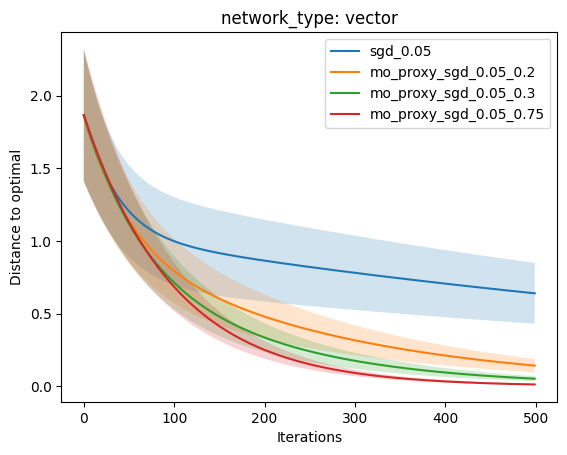

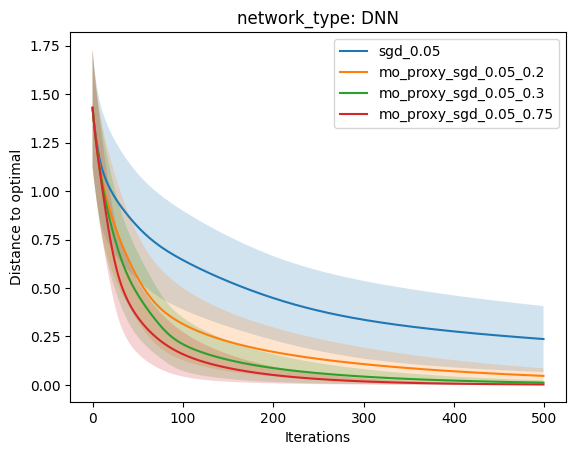

In [ ]:
configs = [
     {
        "name": "sgd",
        "num_steps": 500,
        "learning_rate": 0.01,
        "num_trials": 20,
        "seed": 12345,
        "init_box": 2.0,  # samples initial condition from [-2, 2]^2
        "epsilon": 0.05,
        "proxy_epsilon": 0.75
    },
    {
        "name": "mo_proxy_sgd",
        "num_steps": 500,
        "learning_rate": 0.01,
        "num_trials": 20,
        "seed": 12345,
        "init_box": 2.0,  # samples initial condition from [-2, 2]^2
        "epsilon": 0.05,
        "proxy_epsilon": 0.2
    },
    {
        "name": "mo_proxy_sgd",
        "num_steps": 500,
        "learning_rate": 0.01,
        "num_trials": 20,
        "seed": 12345,
        "init_box": 2.0,  # samples initial condition from [-2, 2]^2
        "epsilon": 0.05,
        "proxy_epsilon": 0.3
    },
    {
        "name": "mo_proxy_sgd",
        "num_steps": 500,
        "learning_rate": 0.01,
        "num_trials": 20,
        "seed": 12345,
        "init_box": 2.0,  # samples initial condition from [-2, 2]^2
        "epsilon": 0.05,
        "proxy_epsilon": 0.75
    }
]

# run configs on a vector input
raw_outputs = {}
for c in configs:
    c.update({"network_type": "vector"})
    id, d, _, _ = benchmark(c)
    raw_outputs[id] = d
plot_res(raw_outputs= raw_outputs, title="network_type: vector")

# run configs on a DNN input
for c in configs:
    c.update({"network_type": "DNN"})
    id, d, _, _ = benchmark(c)
    raw_outputs[id] = d
plot_res(raw_outputs= raw_outputs, title="network_type: DNN")


In [ ]:
Todo:
-) Add primal-dual and best-response algorithms.
-) Add randomness
-) Add batch